## Table of Contents

- [Data Exploration](#explore)
- [ANOVA and Chisquare](#stats)
- [Test Results and Inference](#result)
- [Multilinear Regression](#regression)
- [Interpretation of Regression Result](#regression_result)

<a id='explore'></a>
## Data Exploration

In [1]:
# Import needful libraries

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm

from scipy.stats import chi2_contingency, f_oneway
 
from patsy import dmatrices
import random

%matplotlib inline

In [2]:
# Set random seed to 40
random.seed = 40

In [3]:
# Load data
df = pd.read_csv('yulu_bike_sharing_dataset.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# Explore data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
# Number of unique values in each column
df.nunique()

datetime      10886
season            4
holiday           2
workingday        2
weather           4
temp             49
atemp            60
humidity         89
windspeed        28
casual          309
registered      731
count           822
dtype: int64

##### Data Issues and possible fix
1. Change datetime datatype to Datetime
2. Drop `casual`, and `registered` columns since they add up to give `count`

In [6]:
# Change datetime datatype to Datetime
df.datetime = pd.to_datetime(df.datetime)

In [7]:
# Drop casual, and registered columns
df.drop(['casual', 'registered'], axis = 1, inplace=True)

In [8]:
# Confirm fix implementation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 850.6 KB


In [9]:
# Quick data stats
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000


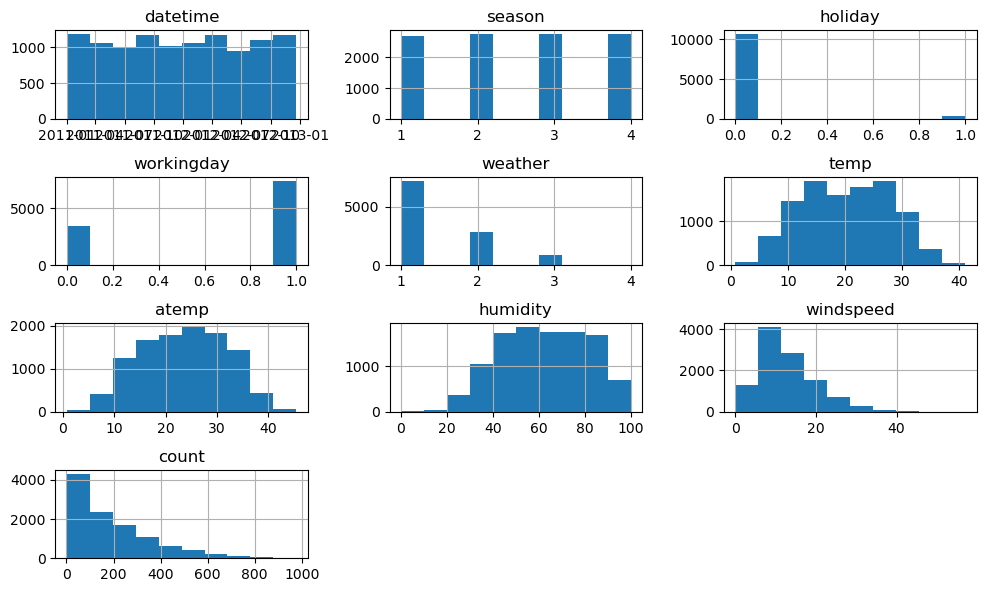

In [10]:
# EDA
df.hist(figsize= [10, 6]);
plt.tight_layout(pad=1.0);

### Result of EDA:
1. There are four categorical columns: `season`, `holiday`, `workingday`, and `weather`
2. `Season` and `weather` have four groups, while `workingday`, and `holiday` have two groups
3. `temp`, `atemp`, and `humidity` are fairly uniformly distributed.
4. `windspeed`, and the target column `count` are right-skewed.

<a id='stats'></a>
## ANOVA and Chisquare 
In this project, I am tasked to make inferences on this data using statistical libraries like ANOVA and chisquare.

### Question 1:
#### Is weather dependent on season (check between 2 predictor variable)

To answer this question, I'll make a chisquare test.<br>
Chisquare is used to analyse the relationship that exists between categorical variables. <br>
> Assumptions of the test:

1. `H0`: All categorical columns are independent
2. `H1`: There exists some significant relationship between categorical columns

In [11]:
# Using chisquare to check the relationship between weather and season
stat, p_val, dof, expctd = chi2_contingency(df[['weather', 'season']])
p_val

1.0

Since the p_val is higher that 0.05, we have enough evidence not to reject the null hypothesis that weather and season are independent variables  

For the nex three questions, I'll use ANOVA to answer<br>

A Quick ANOVA summary:
1. ANOVA means Analysis of Variance.
2. It is used to test the difference in population means between two or more groups
3. `Null hypothesis (H0): population means between groups are the same`
4. `Alternative hypothesis(H1): population means between groups are different`

Main assumptions:

1. Each group is independent with a normal population distribution.
2. The distributions have the same variance.

In this project, the aim is to get the variables that influence electric cycle hiring. So, `count` is the target. The target column is not normally distributed.<br>
However, the one way ANOVA test is considered a robust test against the normality assumption. More information [here](https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide-3.php)<br>

I'll be using one way ANOVA test to investigate the difference in mean number of cycles rented  between groups.<br>
`Type 1 error (Alpha) rate  = 0.05`

### Question 2:
#### Does workingday have effect on number of electric cycles rented?

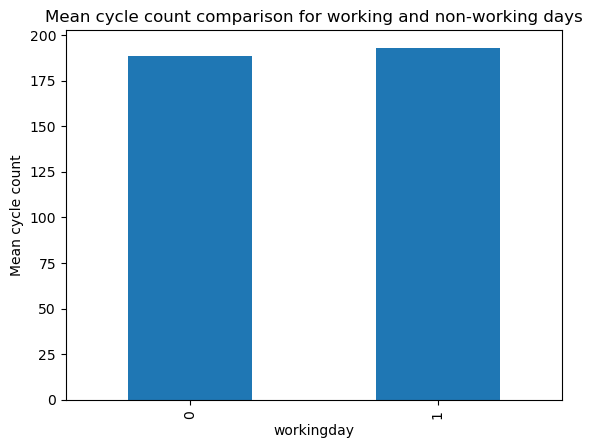

In [12]:
# Check the mean cycle count of each workingday group
df.groupby('workingday')['count'].mean().sort_values().plot(kind = 'bar');
plt.ylabel('Mean cycle count');
plt.title('Mean cycle count comparison for working and non-working days');

In [13]:
# Observed mean difference between groups
df.groupby('workingday')['count'].mean()[1] - df.groupby('workingday')['count'].mean()[0]

4.505252028716285

Remember: workingday = 1, non-workingday = 0.<br>
1 has a slight higher mean of 4.5 than 0.<br>
Let's check whether this difference is actual or by chance

In [14]:
# Dataframe for workingday == 1
working_day = df[df.workingday == 1]

# Dataframe for workingday == 0
no_working_day = df[df.workingday == 0]

In [15]:
# One way ANOVA test for mean difference in the number of cycles rented
# in each workingday group

t1, pval1 = f_oneway(working_day['count'], no_working_day['count'])
pval1

0.22644804226428558

### Question 3:
#### No. of cycles rented similar or different in different weather

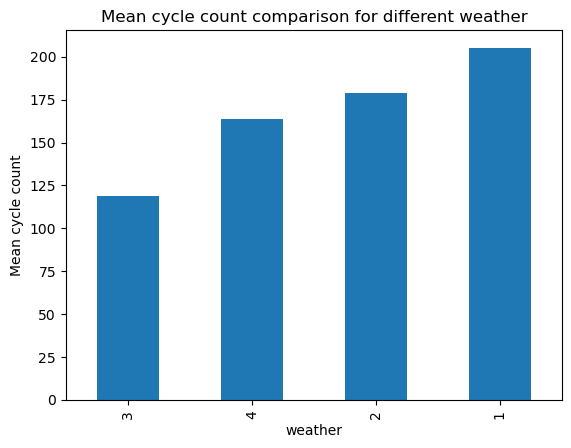

In [16]:
# Check the mean cycle count for each weather
df.groupby('weather')['count'].mean().sort_values().plot(kind = 'bar');
plt.ylabel('Mean cycle count');
plt.title('Mean cycle count comparison for different weather');

In [17]:
# There are 4 weather groups. Separate them into 4 Dataframes 
weather_1 = df[df.weather == 1]
weather_2 = df[df.weather == 2]
weather_3 = df[df.weather == 3]
weather_4 = df[df.weather == 4]

In [18]:
# One way ANOVA test for mean difference in cycle count for each weather
t2, pval2 = f_oneway(weather_1['count'], weather_2['count'], weather_3['count'], weather_4['count'])
pval2

5.482069475935669e-42

### Question 4:
#### No. of cycles rented similar or different in different seasons

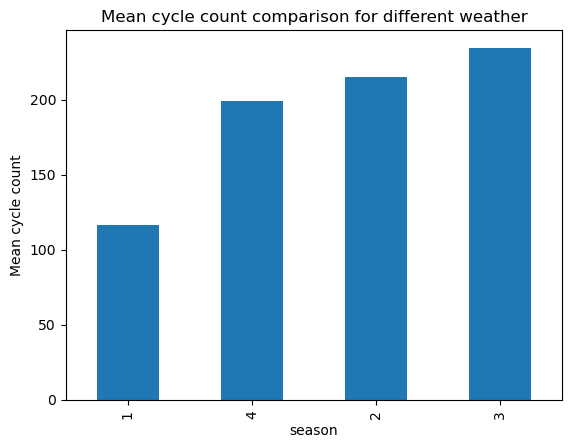

In [19]:
# Check the mean cycle count for each weather
df.groupby('season')['count'].mean().sort_values().plot(kind = 'bar');
plt.ylabel('Mean cycle count');
plt.title('Mean cycle count comparison for different weather');

In [20]:
# Form dataframes for different seasons
season_1 = df[df.season == 1]
season_2 = df[df.season == 2]
season_3 = df[df.season == 3]
season_4 = df[df.season == 4]

In [21]:
# One way ANOVA test for mean difference in cycle count for each season
t3, pval3 = f_oneway(season_1['count'], season_2['count'], season_3['count'], season_4['count'])
pval3

6.164843386499654e-149

In [22]:
# Form a list of p_values
pvals = [pval1, pval2, pval3]

In [23]:
# 3 tests were conducted.
# Adjust the p_values using the Bonferroni method
p_adjusted = multipletests(pvals, alpha=0.05, method='bonferroni')

In [24]:
p_adjusted[1].tolist()

[0.6793441267928567, 1.6446208427807007e-41, 1.8494530159498962e-148]

<a id='result'></a>
### Test Result

1. The adjusted pval2 and pval3 are significant (<0.05), therefore we have an evidence to reject the `H0` that there is no difference in population cycle mean in different seasons and weather.<br>
2. The adjusted pval1 is insignificant (>0.05), hence we have enough evidence not to reject the `H0` that there is no difference in population cycle mean between workingday and non-workingday. <br>

### Inference
> From the tests, we can infer that<br>
1. Working Day has no effect on number of electric cycles rented.
2. No. of cycles rented are different in different seasons.
3. No. of cycles rented are different in different weather.
4. Weather and Season variables are independent columns 

<a id='regression'></a>
## Multilinear Regression

### Question 5:
#### Which variables are significant in predicting the demand for shared electric cycles in the Indian market? How well those variables describe the electric cycle demands?

To answer these questions, I'll use the _statsmodel's ols library_ to form a multilinear regression model.<br> Then I'll use the p_value of each variable to determine their importance.<br>

>   #### Assumptions of ols models:
1. H0: the slope between a predictor and the response is zero
2. H1: the slope between a predictor and the response is not zero<br>

Multilinear models usually have multi-collinearity problems, hence columns should be investigated before building the model.

In [25]:
# Check for multicollinearity with Variance Inflation Factor(VIF)
y, X = dmatrices(
    'count ~ holiday+ workingday + temp + atemp + humidity + windspeed + season + weather', 
    df, return_type = 'dataframe'
)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,34.029472,Intercept
1,1.069731,holiday
2,1.071196,workingday
3,35.516012,temp
4,35.550831,atemp
5,1.425034,humidity
6,1.195704,windspeed
7,1.137211,season
8,1.236150,weather


`atemp`, and `temp` have the highest VIF, hence drop one of them

In [26]:
# Drop atemp and recalculate VIF
y, X = dmatrices('count ~ holiday+ workingday + temp +  humidity + windspeed + season + weather', df, return_type = 'dataframe')


vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,31.375118,Intercept
1,1.068094,holiday
2,1.070025,workingday
3,1.089028,temp
4,1.421256,humidity
5,1.149650,windspeed
6,1.136866,season
7,1.235251,weather


After dropping `atemp`, the issue is solved.

In [27]:
# Copy data to form another df_2
df_2  = df.copy()

# Target variable
target  = df_2['count']

# Dummy categorical variables (season, weather)
df_2[['season', 'weather']] = df_2[['season', 'weather']].astype(str)
df_2 = pd.get_dummies(df_2.drop(['datetime', 'count'], axis = 1))

# Drop 'season_4', 'weather_4' as baseline
df_2.drop(['season_4', 'weather_4'], axis=1, inplace=True)

In [28]:
# Preview df_2
df_2.head(2)

,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,weather_1,weather_2,weather_3
0,0,0,9.84,14.395,81,0.0,1,0,0,1,0,0
1,0,0,9.02,13.635,80,0.0,1,0,0,1,0,0


In [29]:
# Add intercept to df_2
df_2['intercept'] = 1

In [30]:
# Build a linear model with ols
lm = sm.OLS(df['count'], df_2.drop('atemp', axis = 1))

# Fit the model
results = lm.fit()
# Check the summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     377.4
Date:                Sat, 03 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:04:38   Log-Likelihood:                -70285.
No. Observations:               10886   AIC:                         1.406e+05
Df Residuals:                   10874   BIC:                         1.407e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
holiday      -10.3224      9.173     -1.125      0.260     -28.304       7.659
workingday    -3.0296      3.281     -0.923      0.356      -9.461       3.402
temp          11.1490      0.319     34.931      0.000      10.523      11.775
humidity      -2.7921      0.093    -29.919      0.000      -2.975      -2.609
windspeed      0.4888      0.195      2.511      0.012       0.107       0.870
season_1     -65.5223      4.540    -14.431      0.000     -74.422     -56.622
season_2     -67.9034      4.594    -14.780      0.000     -76.909     -58.898
season_3    -104.6226      5.683    -18.410      0.000    -115.762     -93.483
weather_1   -186.7770    154.248     -1.211      0.226    -489.131     115.577
weather_2   -172.8634    154.248     -1.121      0.262    -475.218     129.492
weather_3   -196.6991    154.307     -1.275      0.202    -499.169     105.771
intercept    378.3146    154.637      2.446      0.014      75.198     681.431
==============================================================================
Omnibus:                     2167.629   Durbin-Watson:                   0.442
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4250.528
Skew:                           1.207   Prob(JB):                         0.00
Kurtosis:                       4.883   Cond. No.                     1.43e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Summary of Result
1. R-Squared value is 27%, although not reliable as we are dealing with multilinear model.
2. The p_values: (p>|t|) of `holiday`, `workingday`, `weather` > 0.05. Therefore, we cannot reject `H0`. These columns are not helpful in predicting the response.
3. The rest of the columns are < 0.05. Therefore, we can reject `H0` as the appear to be helpful in predicting the response.

In [31]:
# Drop holiday, workingday,and weather and rebuild the model
lm_2 = sm.OLS(df['count'], df_2.drop(['atemp', 'workingday', 'holiday', 'weather_1', 'weather_2', 'weather_3'], axis = 1))
results_2 = lm_2.fit()
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     686.3
Date:                Sat, 03 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:04:38   Log-Likelihood:                -70298.
No. Observations:               10886   AIC:                         1.406e+05
Df Residuals:                   10879   BIC:                         1.407e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp          11.1636      0.319     35.045      0.000      10.539      11.788
humidity      -2.7635      0.084    -32.912      0.000      -2.928      -2.599
windspeed      0.4499      0.192      2.339      0.019       0.073       0.827
season_1     -65.2879      4.533    -14.404      0.000     -74.173     -56.403
season_2     -68.1446      4.594    -14.832      0.000     -77.150     -59.139
season_3    -105.6846      5.669    -18.641      0.000    -116.797     -94.572
intercept    190.7391      9.569     19.934      0.000     171.983     209.495
==============================================================================
Omnibus:                     2156.946   Durbin-Watson:                   0.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4205.205
Skew:                           1.204   Prob(JB):                         0.00
Kurtosis:                       4.863   Cond. No.                         465.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<a id='regression_result'></a>
#### Interpretation of Regression Result
1. After removing the unhelpful columns, it is observed that R-squared remains at 27%
2. In season_4, the number of electric cycles hired is predicted to be 190.7, holding all other variables constant
3. For every one unit rise in temp, the number of electric cycles hired is predicted to be 11 more than that in season_4, holding all other variables constant
4. For every one unit rise in windspeed, the number of electric cycles hired is predicted to be 0.4 more than that in season_4, holding all other variables constant
5. The number of electric cycles hired in season_1 is predicted to be 65.3 less than that in season_4, holding all other variables constant
6. The number of electric cycles hired in season_2 is predicted to be 68.1 less than that in season_4, holding all other variables constant.
7. The number of electric cycles hired in season_3 is predicted to be 105.6 less than that in season_4, holding all other variables constant.